# Machine Learning Foundation

## Section 1, Part d: Feature Engineering


## Feature Engineering with Linear Regression: Applied to the Ames Housing Data

Using the Ames Housing Data:

Dean De Cock
Truman State University
Journal of Statistics Education Volume 19, Number 3(2011), [www.amstat.org/publications/jse/v19n3/decock.pdf](http://www.amstat.org/publications/jse/v19n3/decock.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0232ENSkillsNetwork30654641-2022-01-01)

In this notebook, we will build some linear regression models to predict housing prices from this data. In particular, we will set out to improve on a baseline set of features via **feature engineering**: deriving new features from our existing data. Feature engineering often makes the difference between a weak model and a strong one.

We will use visual exploration, domain understanding, and intuition to construct new features that will be useful later in the course as we turn to prediction.

**Notebook Contents**

> 1.  Simple EDA
> 2.  One-hot Encoding variables
> 3.  Log transformation for skewed variables
> 4.  Pair plot for features
> 5.  Basic feature engineering: adding polynomial and interaction terms
> 6.  Feature engineering: categories and features derived from category aggregates

## 1. Simple EDA


In [ ]:
# Install required libraries for data analysis and machine learning
!pip install pandas seaborn numpy matplotlib scikit-learn requests

In [ ]:
# Suppress warnings for cleaner notebook output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set up display environment and import necessary libraries
%pylab inline
%config InlineBackend.figure_formats = ['retina']

import pandas as pd  # Data manipulation and analysis
import seaborn as sns  # Data visualization
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Plotting
import requests  # Downloading data from the internet
sns.set()  # Set default seaborn style

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


#### Load the Data, Examine and Explore


In [ ]:
# Download and load the Ames Housing dataset
URL = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0232EN-SkillsNetwork/asset/Ames_Housing_Data.tsv'

# Download the dataset if it does not exist
import os
if not os.path.exists('Ames_Housing_Data.tsv'):
    r = requests.get(URL)
    with open('Ames_Housing_Data.tsv', 'wb') as f:
        f.write(r.content)

# Read the dataset into a DataFrame
# sep='\t' to read TSV (tab-separated values) file
df = pd.read_csv('Ames_Housing_Data.tsv', sep='\t')

Saved as 'Ames_Housing_Data.tsv'


In [ ]:
# Check general information about columns and missing values
# This helps identify data types and columns with null values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [ ]:
# Remove outliers as recommended by the dataset author
# Keep only rows with Gr Liv Area (above ground living area) <= 4000
# This helps prevent the model from being affected by extreme values

df = df.loc[df['Gr Liv Area'] <= 4000, :]
print("Number of rows in the data:", df.shape[0])
print("Number of columns in the data:", df.shape[1])

# Save a copy of the original data for later use
data = df.copy()

Number of rows in the data: 2925
Number of columns in the data: 82


In [ ]:
# Preview the first 5 rows of the data to understand its structure and values
print(df.head())

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0        0       5    2010       WD           Normal     215000  
1        0       6    2010       WD           Normal     105000  
2    12500       6    2010       WD           Normal     172000  
3        0       4    2010       WD           Normal     244000  
4        0       3    2010       WD           Normal     189900  

[5 rows x 82 columns]

We're going to first do some basic data cleaning on this data:

*   Converting categorical variables to dummies
*   Making skew variables symmetric

### One-hot encoding for dummy variables:


In [ ]:
# Get the list of string (categorical) columns for one-hot encoding
one_hot_encode_cols = df.dtypes[df.dtypes == 'object']  # Filter object columns
one_hot_encode_cols = one_hot_encode_cols.index.tolist()  # Get column names

# Preview the first 5 rows of categorical columns
print(df[one_hot_encode_cols].head().T)

0        1        2        3        4
MS Zoning            RL       RH       RL       RL       RL
Street             Pave     Pave     Pave     Pave     Pave
Alley               NaN      NaN      NaN      NaN      NaN
Lot Shape           IR1      Reg      IR1      Reg      IR1
Land Contour        Lvl      Lvl      Lvl      Lvl      Lvl
Utilities        AllPub   AllPub   AllPub   AllPub   AllPub
Lot Config       Corner   Inside   Corner   Corner   Inside
Land Slope          Gtl      Gtl      Gtl      Gtl      Gtl
Neighborhood      NAmes    NAmes    NAmes    NAmes  Gilbert
Condition 1        Norm    Feedr     Norm     Norm     Norm
Condition 2        Norm     Norm     Norm     Norm     Norm
Bldg Type          1Fam     1Fam     1Fam     1Fam     1Fam
House Style      1Story   1Story   1Story   1Story   2Story
Roof Style          Hip    Gable      Hip      Hip    Gable
Roof Matl       CompShg  CompShg  CompShg  CompShg  CompShg
Exterior 1st    BrkFace  VinylSd  Wd Sdng  BrkFace  VinylSd
Exterior 2nd    Plywood  VinylSd  Wd Sdng  BrkFace  VinylSd
Mas Vnr Type      Stone      NaN  BrkFace      NaN      NaN
Exter Qual           TA       TA       TA       Gd       TA
Exter Cond           TA       TA       TA       TA       TA
Foundation       CBlock   CBlock   CBlock   CBlock    PConc
Bsmt Qual            TA       TA       TA       TA       Gd
Bsmt Cond            Gd       TA       TA       TA       TA
Bsmt Exposure        Gd       No       No       No       No
BsmtFin Type 1      BLQ      Rec      ALQ      ALQ      GLQ
BsmtFin Type 2      Unf      LwQ      Unf      Unf      Unf
Heating            GasA     GasA     GasA     GasA     GasA
Heating QC           Fa       TA       TA       Ex       Gd
Central Air           Y        Y        Y        Y        Y
Electrical        SBrkr    SBrkr    SBrkr    SBrkr    SBrkr
Kitchen Qual         TA       TA       Gd       Ex       TA
Functional          Typ      Typ      Typ      Typ      Typ
Fireplace Qu         Gd      NaN      NaN       TA       TA
Garage Type      Attchd   Attchd   Attchd   Attchd   Attchd
Garage Finish       Fin      Unf      Unf      Fin      Fin
Garage Qual          TA       TA       TA       TA       TA
Garage Cond          TA       TA       TA       TA       TA
Paved Drive           P        Y        Y        Y        Y
Pool QC             NaN      NaN      NaN      NaN      NaN
Fence               NaN    MnPrv      NaN      NaN    MnPrv
Misc Feature        NaN      NaN     Gar2      NaN      NaN
Sale Type           WD       WD       WD       WD       WD 
Sale Condition   Normal   Normal   Normal   Normal   Normal

### Tiền xử lý dữ liệu: One-hot encoding và làm đối xứng biến skew

Ở bước này, chúng ta sẽ chuyển các biến phân loại thành biến số (one-hot encoding) và xử lý các biến số thực có phân phối lệch bằng log-transform.

In [ ]:
# Perform one-hot encoding for categorical variables
# drop_first=True to avoid dummy variable trap (multicollinearity)
df = pd.get_dummies(df, columns=one_hot_encode_cols, drop_first=True)

# Show descriptive statistics of variables after one-hot encoding
print(df.describe().T)

count          mean           std          min  \
Order            2925.0  1.464795e+03  8.464417e+02          1.0   
PID              2925.0  7.143931e+08  1.887274e+08  526301100.0   
MS SubClass      2925.0  5.739658e+01  4.266875e+01         20.0   
Lot Frontage     2435.0  6.902382e+01  2.271092e+01         21.0   
Lot Area         2925.0  1.010358e+04  7.781999e+03       1300.0   
Overall Qual     2925.0  6.088205e+00  1.402953e+00          1.0   
Overall Cond     2925.0  5.563761e+00  1.112262e+00          1.0   
Year Built       2925.0  1.971303e+03  3.024247e+01       1872.0   
Year Remod/Add   2925.0  1.984234e+03  2.086177e+01       1950.0   
Mas Vnr Area     2902.0  1.007105e+02  1.760343e+02          0.0   
BsmtFin SF 1     2924.0  4.380975e+02  4.380323e+02          0.0   
BsmtFin SF 2     2924.0  4.980746e+01  1.693006e+02          0.0   
Bsmt Unf SF      2924.0  5.589473e+02  4.396214e+02          0.0   
Total Bsmt SF    2924.0  1.046852e+03  4.211095e+02          0.0   
1st Flr SF       2925.0  1.155461e+03  3.765920e+02        334.0   
2nd Flr SF       2925.0  3.338328e+02  4.258420e+02          0.0   
Low Qual Fin SF  2925.0  4.684786e+00  4.634968e+01          0.0   
Gr Liv Area      2925.0  1.493979e+03  4.862736e+02        334.0   
Bsmt Full Bath   2923.0  4.303797e-01  5.240886e-01          0.0   
Bsmt Half Bath   2923.0  6.055423e-02  2.442227e-01          0.0   
Full Bath        2925.0  1.564786e+00  5.513858e-01          0.0   
Half Bath        2925.0  3.784615e-01  5.024029e-01          0.0   
Bedroom AbvGr    2925.0  2.853675e+00  8.277367e-01          0.0   
Kitchen AbvGr    2925.0  1.044444e+00  2.142513e-01          0.0   
TotRms AbvGrd    2925.0  6.434188e+00  1.557887e+00          2.0   
Fireplaces       2925.0  5.969231e-01  6.453486e-01          0.0   
Garage Yr Blt    2766.0  1.978088e+03  2.552887e+01       1895.0   
Garage Cars      2924.0  1.765048e+00  7.598341e-01          0.0   
Garage Area      2924.0  4.718837e+02  2.138160e+02          0.0   
Wood Deck SF     2925.0  9.339214e+01  1.260341e+02          0.0   
Open Porch SF    2925.0  4.716684e+01  6.657181e+01          0.0   
Enclosed Porch   2925.0  2.305094e+01  6.418681e+01          0.0   
3Ssn Porch       2925.0  2.596923e+00  2.516259e+01          0.0   
Screen Porch     2925.0  1.602940e+01  5.613140e+01          0.0   
Pool Area        2925.0  1.893333e+00  3.296427e+01          0.0   
Misc Val         2925.0  4.490974e+01  4.722380e+02          0.0   
Mo Sold          2925.0  6.216752e+00  2.711541e+00          1.0   
Yr Sold          2925.0  2.007791e+03  1.317408e+00       2006.0   
SalePrice        2925.0  1.804116e+05  7.855486e+04      12789.0   

                          25%          50%           75%           max  
Order            7.320000e+02       1463.0  2.199000e+03  2.930000e+03  
PID              5.284770e+08  535453210.0  9.071801e+08  1.007100e+09  
MS SubClass      2.000000e+01         50.0  7.000000e+01  1.900000e+02  
Lot Frontage     5.800000e+01         68.0  8.000000e+01  3.130000e+02  
Lot Area         7.438000e+03       9428.0  1.151500e+04  2.152450e+05  
Overall Qual     5.000000e+00          6.0  7.000000e+00  1.000000e+01  
Overall Cond     5.000000e+00          5.0  6.000000e+00  9.000000e+00  
Year Built       1.954000e+03       1973.0  2.001000e+03  2.010000e+03  
Year Remod/Add   1.965000e+03       1993.0  2.004000e+03  2.010000e+03  
Mas Vnr Area     0.000000e+00          0.0  1.640000e+02  1.600000e+03  
BsmtFin SF 1     0.000000e+00        369.5  7.332500e+02  2.288000e+03  
BsmtFin SF 2     0.000000e+00          0.0  0.000000e+00  1.526000e+03  
Bsmt Unf SF      2.187500e+02        464.5  8.010000e+02  2.336000e+03  
Total Bsmt SF    7.927500e+02        989.5  1.299250e+03  3.206000e+03  
1st Flr SF       8.760000e+02       1082.0  1.383000e+03  3.820000e+03  
2nd Flr SF       0.000000e+00          0.0  7.020000e+02  1.862000e+03  
Low Qual Fin SF  0.000000e+00          0.0  0.000000e+00

### Log-transform các biến có phân phối lệch

Các biến số thực có độ lệch lớn sẽ được log-transform để phân phối gần chuẩn hơn, giúp mô hình học tốt hơn.

In [ ]:
# Find float columns to check for skewness
mask = data.dtypes == 'float64'
float_cols = data.columns[mask]

# Set skew_limit, variables with absolute skewness above this will be log-transformed
skew_limit = 0.75
skew_vals = data[float_cols].skew()  # Calculate skewness for each variable

In [ ]:
# Display variables with skewness greater than skew_limit
skew_cols = (
    skew_vals.sort_values(ascending=False)
    .to_frame()
    .rename(columns={0: 'Skew'})
    .query('abs(Skew) > @skew_limit')
)
print(skew_cols)

Skew
BsmtFin SF 2    4.135900
Bsmt Half Bath  3.965970
Mas Vnr Area    2.565458
Lot Frontage    1.111071
Bsmt Unf SF     0.925021
BsmtFin SF 1    0.821985

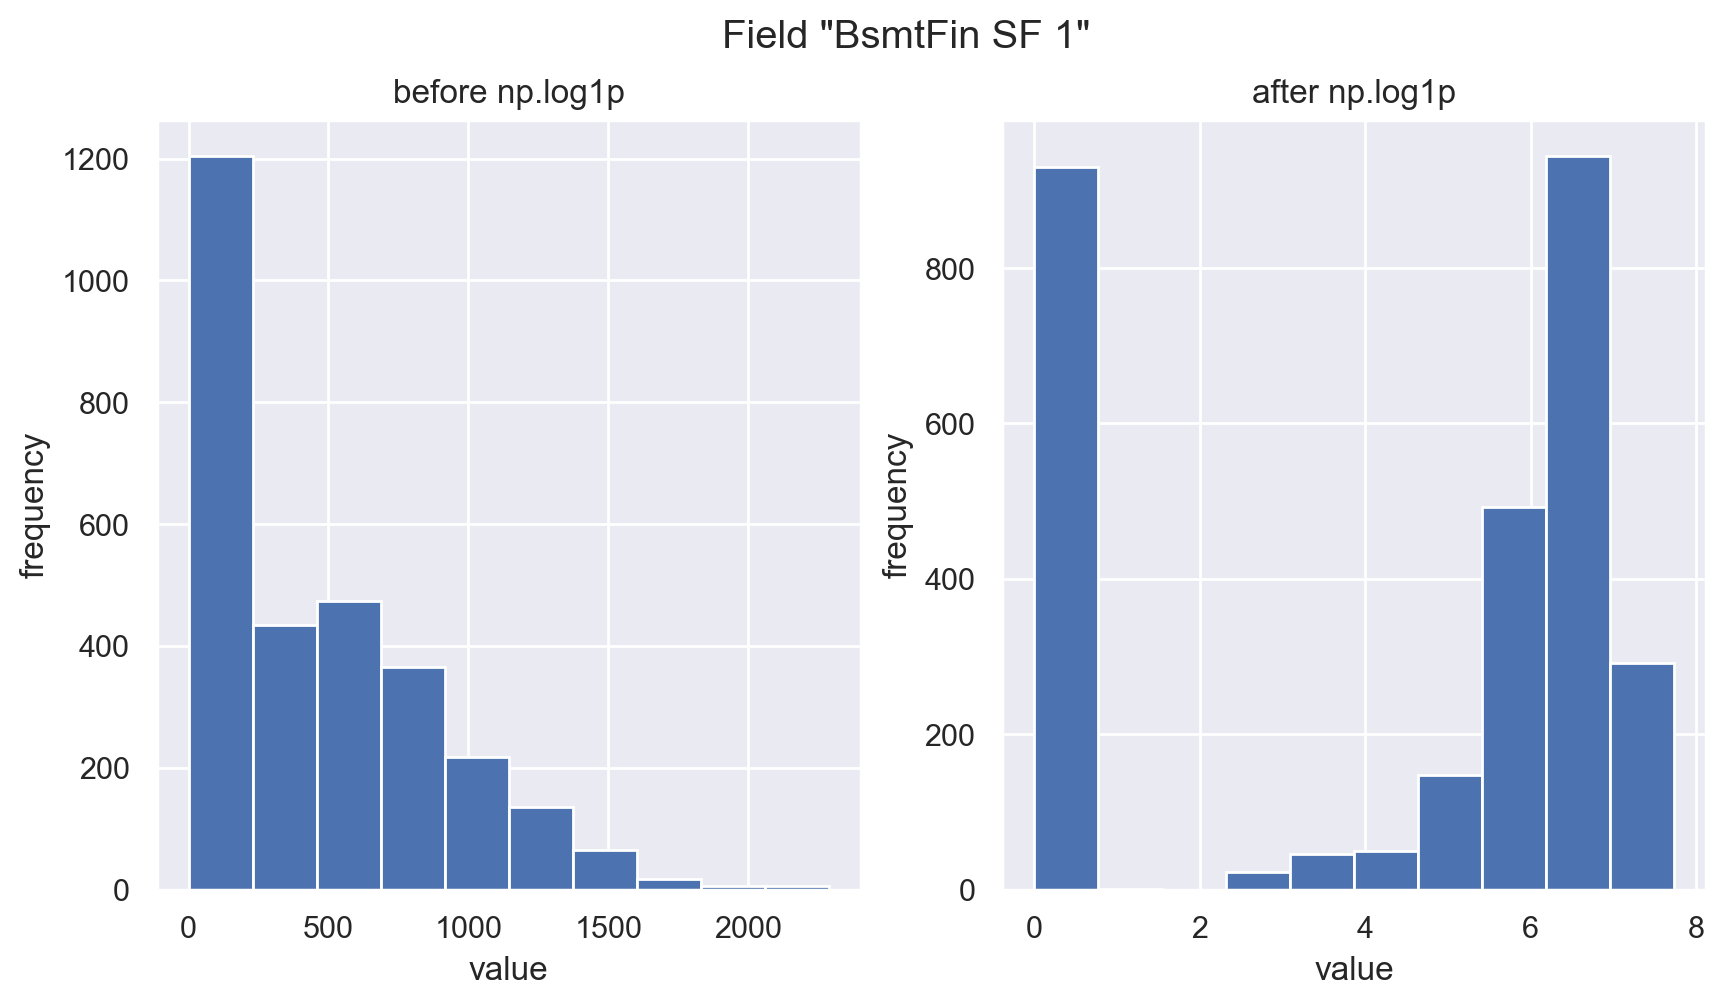

In [ ]:
# Visualize the effect of log-transform on a skewed variable

# Choose a variable with high skewness
field = "BsmtFin SF 1"

# Create two histograms before and after log-transform
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(10, 5))

# Histogram before log-transform
ax_before.hist(df[field], bins=30)
ax_before.set(title='before np.log1p', ylabel='frequency', xlabel='value')

# Histogram after log-transform
ax_after.hist(np.log1p(df[field]), bins=30)
ax_after.set(title='after np.log1p', ylabel='frequency', xlabel='value')

fig.suptitle(f'Field "{field}"')
plt.show()

In [ ]:
# Apply log-transform to variables with high skewness (except SalePrice)
for col in skew_cols.index.values:
    if col == "SalePrice":
        continue
    df[col] = np.log1p(df[col])  # np.log1p(x) = log(1 + x), safe for zero values

In [ ]:
# Check the shape of the data after feature transformation
print(df.shape)

(2925, 261)

In [ ]:
# Return to the original data to check the number of missing values for each variable
# Sorted in ascending order to easily spot variables with many missing values
df = data
print(data.isnull().sum().sort_values())

Order              0
PID                0
MS SubClass        0
MS Zoning          0
Lot Area           0
                ... 
Mas Vnr Type    1774
Fence           2354
Alley           2727
Misc Feature    2820
Pool QC         2914
Length: 82, dtype: int64

### Lựa chọn một số biến số để minh họa biến đổi đặc trưng

Chúng ta sẽ chọn một tập con các biến số để thực hiện các bước biến đổi đặc trưng cơ bản và trực quan hóa.

In [ ]:
# Select a subset of numeric variables to illustrate basic feature transformations
smaller_df = df.loc[:, [
    'Lot Area', 'Overall Qual', 'Overall Cond',
    'Year Built', 'Year Remod/Add', 'Gr Liv Area',
    'Full Bath', 'Bedroom AbvGr', 'Fireplaces',
    'Garage Cars', 'SalePrice'
]]

In [ ]:
# Show descriptive statistics for the selected subset of variables
print(smaller_df.describe().T)

count           mean           std      min       25%  \
Lot Area        2925.0   10103.583590   7781.999124   1300.0    7438.0   
Overall Qual    2925.0       6.088205      1.402953      1.0       5.0   
Overall Cond    2925.0       5.563761      1.112262      1.0       5.0   
Year Built      2925.0    1971.302906     30.242474   1872.0    1954.0   
Year Remod/Add  2925.0    1984.234188     20.861774   1950.0    1965.0   
Gr Liv Area     2925.0    1493.978803    486.273646    334.0    1126.0   
Full Bath       2925.0       1.564786      0.551386      0.0       1.0   
Bedroom AbvGr   2925.0       2.853675      0.827737      0.0       2.0   
Fireplaces      2925.0       0.596923      0.645349      0.0       0.0   
Garage Cars     2924.0       1.765048      0.759834      0.0       1.0   
SalePrice       2925.0  180411.574701  78554.857286  12789.0  129500.0   

                     50%       75%       max  
Lot Area          9428.0   11515.0  215245.0  
Overall Qual         6.0       7.0      10.0  
Overall Cond         5.0       6.0       9.0  
Year Built        1973.0    2001.0    2010.0  
Year Remod/Add    1993.0    2004.0    2010.0  
Gr Liv Area       1441.0    1740.0    3820.0  
Full Bath            2.0       2.0       4.0  
Bedroom AbvGr        3.0       3.0       8.0  
Fireplaces           1.0       1.0       4.0  
Garage Cars          2.0       2.0       5.0  
SalePrice       160000.0  213500.0  625000.0

In [ ]:
# Check info about missing values in the selected subset
print(smaller_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2925 entries, 0 to 2929
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Area        2925 non-null   int64  
 1   Overall Qual    2925 non-null   int64  
 2   Overall Cond    2925 non-null   int64  
 3   Year Built      2925 non-null   int64  
 4   Year Remod/Add  2925 non-null   int64  
 5   Gr Liv Area     2925 non-null   int64  
 6   Full Bath       2925 non-null   int64  
 7   Bedroom AbvGr   2925 non-null   int64  
 8   Fireplaces      2925 non-null   int64  
 9   Garage Cars     2924 non-null   float64
 10  SalePrice       2925 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 274.2 KB


In [ ]:
# Handle missing values in 'Garage Cars' by filling with 0
smaller_df = smaller_df.fillna(0)

In [ ]:
# Check info again after handling missing values
print(smaller_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2925 entries, 0 to 2929
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Area        2925 non-null   int64  
 1   Overall Qual    2925 non-null   int64  
 2   Overall Cond    2925 non-null   int64  
 3   Year Built      2925 non-null   int64  
 4   Year Remod/Add  2925 non-null   int64  
 5   Gr Liv Area     2925 non-null   int64  
 6   Full Bath       2925 non-null   int64  
 7   Bedroom AbvGr   2925 non-null   int64  
 8   Fireplaces      2925 non-null   int64  
 9   Garage Cars     2925 non-null   float64
 10  SalePrice       2925 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 274.2 KB


### Trực quan hóa mối quan hệ giữa các biến số và SalePrice

Sử dụng pairplot để quan sát mối quan hệ giữa các biến số và biến mục tiêu SalePrice.

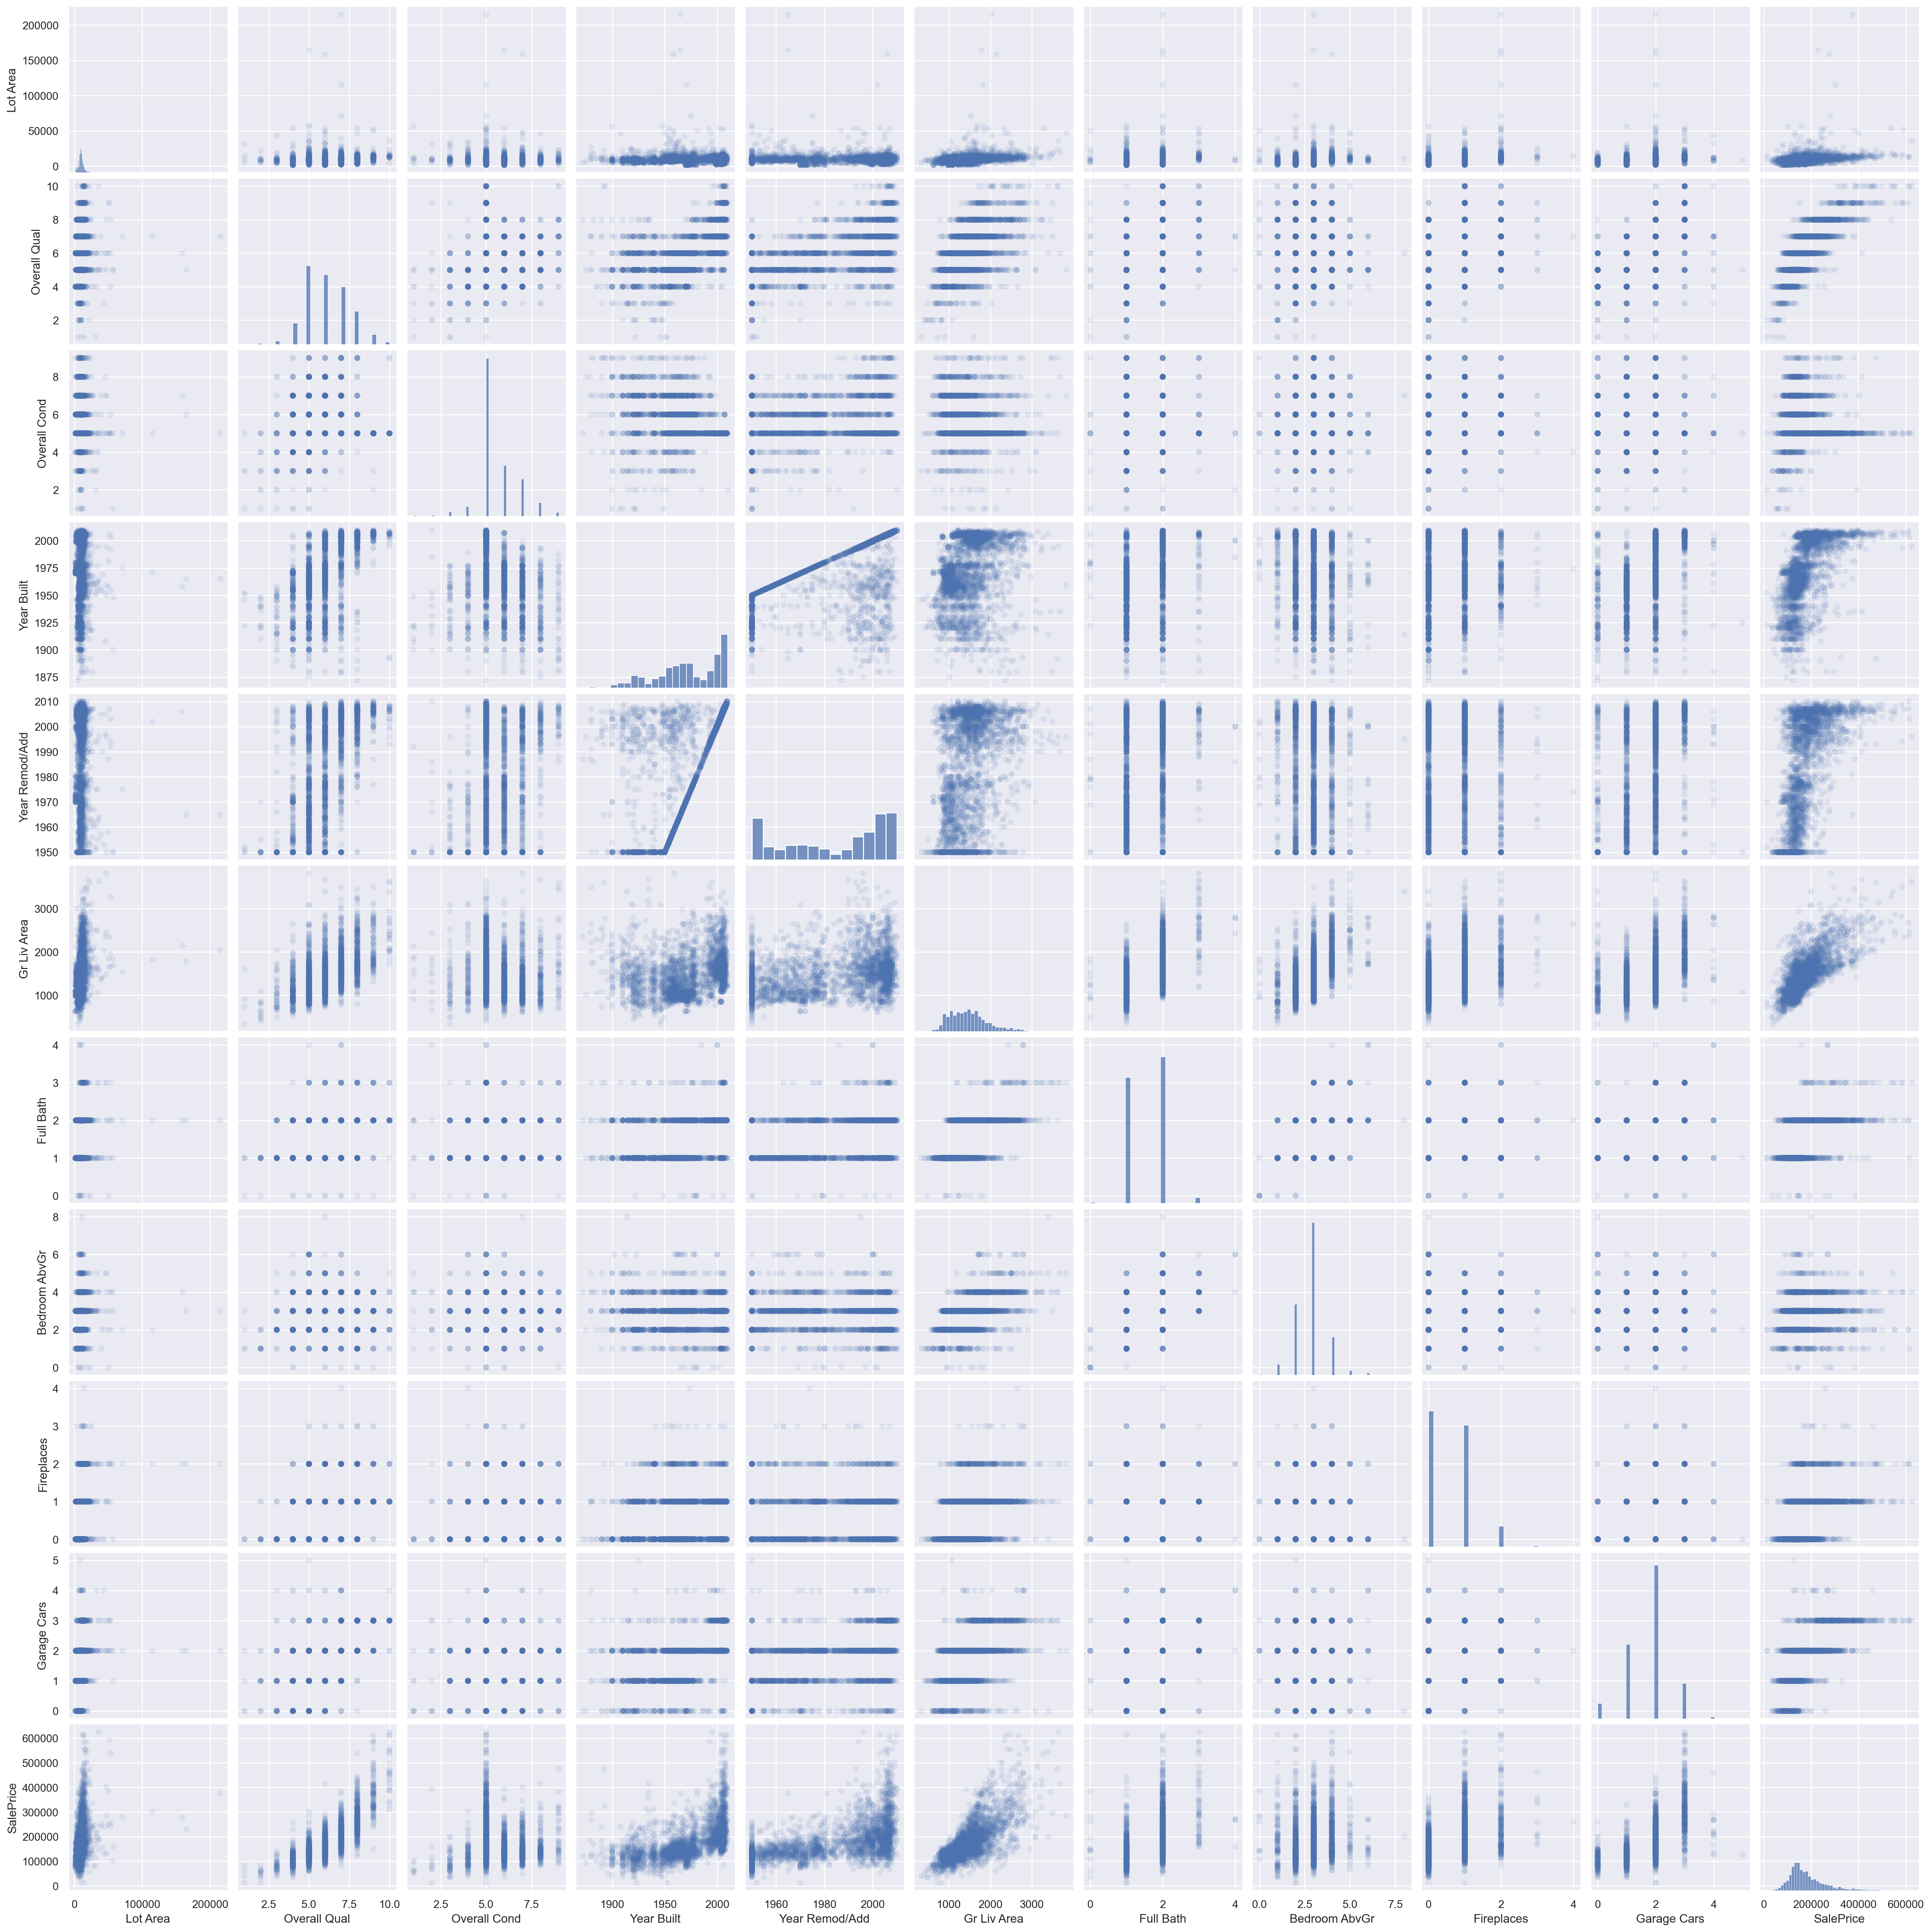

In [ ]:
# Visualize pairwise relationships between numeric features and SalePrice
sns.pairplot(smaller_df, plot_kws=dict(alpha=.1, edgecolor='none'))
plt.show()

---
**Data Exploration Discussion**: 

1. What do these plots tell us about the distribution of the target?   

2. What do these plots tell us about the relationship between the features and the target? Do you think that linear regression is well-suited to this problem? Do any feature transformations come to mind?

3. What do these plots tell us about the relationship between various pairs of features? Do you think there may be any problems here? 

---


#### Tách biến đầu vào (features) và biến mục tiêu (target)

Chúng ta sẽ tách các biến đầu vào và biến mục tiêu để chuẩn bị cho các bước xây dựng mô hình tiếp theo.

In [ ]:
# Separate features (X) and target (y) for modeling
X = smaller_df.loc[:, [
    'Lot Area', 'Overall Qual', 'Overall Cond',
    'Year Built', 'Year Remod/Add', 'Gr Liv Area',
    'Full Bath', 'Bedroom AbvGr', 'Fireplaces',
    'Garage Cars']
]
y = smaller_df['SalePrice']

In [ ]:
# Check info of input features X
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2925 entries, 0 to 2929
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Area        2925 non-null   int64  
 1   Overall Qual    2925 non-null   int64  
 2   Overall Cond    2925 non-null   int64  
 3   Year Built      2925 non-null   int64  
 4   Year Remod/Add  2925 non-null   int64  
 5   Gr Liv Area     2925 non-null   int64  
 6   Full Bath       2925 non-null   int64  
 7   Bedroom AbvGr   2925 non-null   int64  
 8   Fireplaces      2925 non-null   int64  
 9   Garage Cars     2925 non-null   float64
dtypes: float64(1), int64(9)
memory usage: 251.4 KB


### Chuẩn bị dữ liệu cho mô hình hóa

Sau khi có X, y, chúng ta có thể chia tập train/validation và xây dựng các hàm tiện ích để đánh giá mô hình với các bộ đặc trưng khác nhau.

Great, let's go ahead and run this function on our baseline feature set and take some time to analyze the results.


### Feature engineering cơ bản: thêm biến đa thức và biến tương tác

Thêm các biến bình phương và biến tương tác để mô hình hóa các quan hệ phi tuyến và phụ thuộc giữa các đặc trưng.

One of the first things that we looked for in the pairplot was evidence about the relationship between each feature and the target. In certain features like *'Overall Qual'* and *'Gr Liv Qual'*, we notice an upward-curved relationship rather than a simple linear correspondence. This suggests that we should add quadratic **polynomial terms or transformations** for those features, allowing us to express that non-linear relationship while still using linear regression as our model.

Luckily, pandas makes it quite easy to quickly add those square terms as additional features to our original feature set. We'll do so and evaluate our model again below.

As we add to our baseline set of features, we'll create a copy of the latest benchmark so that we can continue to store our older feature sets.

### Polynomial Features


In [ ]:
# Add polynomial (squared) features to model non-linear relationships
X2 = X.copy()
X2['OQ2'] = X2['Overall Qual'] ** 2  # Square of Overall Qual
X2['GLA2'] = X2['Gr Liv Area'] ** 2  # Square of Gr Liv Area

As is, each feature is treated as an independent quantity. However, there may be **interaction effects**, in which the impact of one feature may dependent on the current value of a different feature.

For example, there may be a higher premium for increasing *'Overall Qual'* for houses that were built more recently. If such a premium or a similar effect exists, a feature that multiplies *'Overall Qual'* by *'Year Built'* can help us capture it.

Another style of interaction term involves feature proprtions: for example, to get at something like quality per square foot we could divide *'Overall Qual'* by *'Lot Area'*.

Let's try adding both of these interaction terms and see how they impact the model results.

### Feature interactions


In [ ]:
# Add interaction features between variables
X3 = X2.copy()

# Multiplicative interaction between Overall Qual and Year Built
X3['OQ_x_YB'] = X3['Overall Qual'] * X3['Year Built']

# Ratio interaction between Overall Qual and Lot Area
X3['OQ_/_LA'] = X3['Overall Qual'] / X3['Lot Area']

***

**Interaction Feature Exercise**: What other interactions do you think might be helpful? Why?

***


### Thêm đặc trưng từ biến phân loại (category aggregates)

Tạo các đặc trưng mới dựa trên thông tin nhóm (category), ví dụ như Neighborhood hoặc House Style.

Incorporating **categorical features** into linear regression models is fairly straightforward: we can create a new feature column for each category value, and fill these columns with 1s and 0s to indicate which category is present for each row. This method is called **dummy variables** or **one-hot-encoding**.

We'll first explore this using the *'House Style'* feature from the original dataframe. Before going straight to dummy variables, it's a good idea to check category counts to make sure all categories have reasonable representation.


In [ ]:
# Count the number of each House Style in the original data
print(data['House Style'].value_counts())

House Style
1Story    1480
2Story     869
1.5Fin     314
SLvl       128
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: count, dtype: int64

This looks ok, and here's a quick look at how dummy features actually appear:


In [ ]:
# Preview dummy variables after one-hot encoding House Style
print(pd.get_dummies(df['House Style'], drop_first=True).head())

1.5Unf  1Story  2.5Fin  2.5Unf  2Story  SFoyer   SLvl
0   False    True   False   False   False   False  False
1   False    True   False   False   False   False  False
2   False    True   False   False   False   False  False
3   False    True   False   False   False   False  False
4   False   False   False   False    True   False  False

Chúng ta có thể sử dụng `pd.get_dummies()` để chuyển toàn bộ các biến phân loại thành biến số (dummy variables) một cách nhanh chóng.

In [ ]:
# Count the number of each Neighborhood
nbh_counts = df.Neighborhood.value_counts()
print(nbh_counts)

Neighborhood
NAmes      443
CollgCr    267
OldTown    239
Edwards    191
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     69
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: count, dtype: int64

Đối với biến Neighborhood, chúng ta sẽ gộp các nhóm có số lượng rất nhỏ thành một nhóm 'Other' để tránh gây nhiễu cho mô hình.

In [ ]:
# Identify Neighborhoods with very few occurrences (<=8)
other_nbhs = list(nbh_counts[nbh_counts <= 8].index)
print(other_nbhs)

['Greens', 'GrnHill', 'Landmrk']

In [ ]:
# Add Neighborhood feature with rare groups merged as 'Other' to the feature set
X4 = X3.copy()
X4['Neighborhood'] = df['Neighborhood'].replace(other_nbhs, 'Other')

#### Getting to fancier features

Let's close out our introduction to feature engineering by considering a more complex type of feature that may work very nicely for certain problems. It doesn't seem to add a great deal over what we have so far, but it's a style of engineering to keep in mind for the future.

We'll create features that capture where a feature value lies relative to the members of a category it belongs to. In particular, we'll calculate deviance of a row's feature value from the mean value of the category that row belongs to. This helps to capture information about a feature relative to the category's distribution, e.g. how nice a house is relative to other houses in its neighborhood or of its style.

Below we define reusable code for generating features of this form, feel free to repurpose it for future feature engineering work!


In [ ]:
# Function to create a standardized deviation feature for a variable relative to its category mean
# This helps the model learn relative information within each group

def add_deviation_feature(X, feature, category):
    # Group by category and get feature values
    category_gb = X.groupby(category)[feature]
    # Mean and std for each group
    category_mean = category_gb.transform(lambda x: x.mean())
    category_std = category_gb.transform(lambda x: x.std())
    # Calculate standardized deviation from group mean
    deviation_feature = (X[feature] - category_mean) / category_std
    X[feature + '_Dev_' + category] = deviation_feature

Bây giờ chúng ta sẽ sử dụng hàm tạo biến độ lệch chuẩn hóa để thêm các đặc trưng mới vào tập dữ liệu.

In [ ]:
# Add two standardized deviation features to the feature set
X5 = X4.copy()
X5['House Style'] = df['House Style']
add_deviation_feature(X5, 'Year Built', 'House Style')
add_deviation_feature(X5, 'Overall Qual', 'Neighborhood')

## Tạo biến đa thức tự động với Scikit-Learn

Sử dụng PolynomialFeatures để sinh các biến đa thức và biến tương tác một cách tự động cho các mô hình tuyến tính.

In [ ]:
# Use PolynomialFeatures from sklearn to automatically create polynomial and interaction features
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# Initialize PolynomialFeatures with degree 2 (includes original, squared, and interaction terms)
pf = PolynomialFeatures(degree=2)

In [ ]:
# Fit PolynomialFeatures for two variables: Lot Area and Overall Qual
features = ['Lot Area', 'Overall Qual']
pf.fit(df[features])

PolynomialFeatures()

In [ ]:
# Show the names of the features after polynomial transformation
print(pf.get_feature_names_out(input_features=features))

['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2']

In [ ]:
# Transform the data and display a DataFrame of the polynomial features
feat_array = pf.transform(df[features])
print(pd.DataFrame(feat_array, columns=pf.get_feature_names_out(input_features=features)).head())

1  Lot Area  Overall Qual    Lot Area^2  Lot Area Overall Qual  \
0     1.0   31770.0           6.0  1.009333e+09               190620.0   
1     1.0   11622.0           5.0  1.350709e+08                58110.0   
2     1.0   14267.0           6.0  2.035473e+08                85602.0   
3     1.0   11160.0           7.0  1.245456e+08                78120.0   
4     1.0   13830.0           5.0  1.912689e+08                69150.0   
...   ...       ...           ...           ...                    ...   
2920  1.0    7937.0           6.0  6.299597e+07                47622.0   
2921  1.0    8885.0           5.0  7.894322e+07                44425.0   
2922  1.0   10441.0           5.0  1.090145e+08                52205.0   
2923  1.0   10010.0           5.0  1.002001e+08                50050.0   
2924  1.0    9627.0           7.0  9.267913e+07                67389.0   

      Overall Qual^2  
0               36.0  
1               25.0  
2               36.0  
3               49.0  
4               25.0  
...              ...  
2920            36.0  
2921            25.0  
2922            25.0  
2923            25.0  
2924            49.0  

[2925 rows x 6 columns]

## Recap

While we haven't yet turned to prediction, these feature engineering exercises set the stage. Generally, feature engineering often follows a sort of [*Pareto principle*](https://en.wikipedia.org/wiki/Pareto_principle?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0232ENSkillsNetwork30654641-2022-01-01), where a large bulk of the predictive gains can be reached through adding a set of intuitive, strong features like polynomial transforms and interactions. Directly incorporating additional information like categorical variables can also be very helpful. Beyond this point, additional feature engineering can provide significant, but potentially diminishing returns. Whether it's worth it depends on the use case for the model.


***

### Machine Learning Foundation (C) 2020 IBM Corporation
